<a href="https://colab.research.google.com/github/Raahim58/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. Model Deployment with PyTorch (Project 3)

What is model deployment?

ML model deployment is the act of making your machine learning model(s) availablem to someone or something else.

**Resources:**

* Resource notebook: https://www.learnpytorch.io/09_pytorch_model_deployment/

* Ask questions: https://github.com/mrdbourke/pytorch-...

* Access code: https://github.com/mrdbourke/pytorch-deep-learning

* Ground truth notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb

* PyTorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html


## 0. Get setup

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

The dataser we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

We can get data with code from here: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline



### 3 questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
  * Latency = time for prediction to take place

To try and achieve these goals, we're going to build two model experiments:
1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

## 3. Experiment 1: Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) cuztomized to a certain problem.

EffNetB2 pretrained model in PyTorch: https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [ ]:
import torchvision
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # 'DEFAULT' is equivalent to saying 'best available weights'

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms() # want to format our custom data in the same format the pre-trained model was trained on

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights) # could also use weights = "DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 129MB/s]


In [ ]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace=True),
    nn.Linear(in_features = 1408, out_features = 3, bias = True)
)

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [ ]:
# After adjusting classifier head
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(effnetb2,
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes: int = 3, # default output classes = 3 (pizza, steak, sushi)
                          seed: int = 42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes),
  )

  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3,
                                                      seed = 42)

In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# From our effnetb2 function
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(effnetb2,
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2

In [ ]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                 test_dir = test_dir,
                                                                                                 transform = effnetb2_transforms,
                                                                                                 batch_size = 32)

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr=0.001)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                epochs = 10,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves

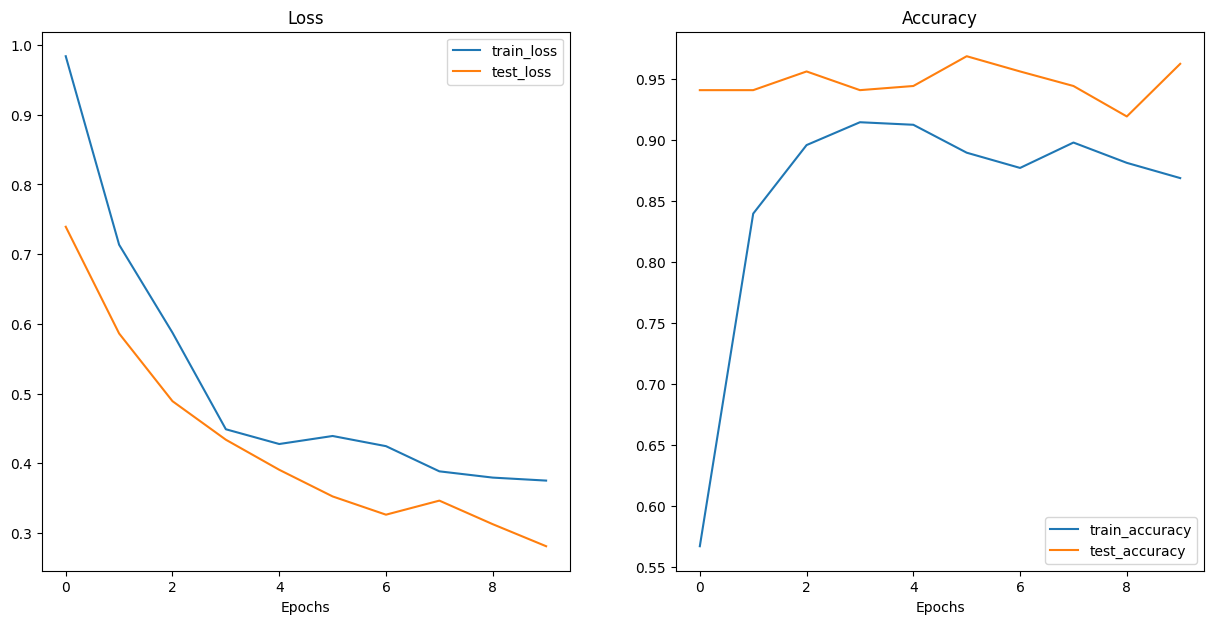

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

Model overfitts if train_loss is less than test_loss which isn't over here

### 3.5 Saving EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model = effnetb2,
                 target_dir = "models",
                 model_name = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Checking the size of the EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [ ]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size:.2f} MB")

Pretrained EffNetB2 feature extractor model size: 29.00 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2 (more calculations if more parameters so will take longer mostly)
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Experiment 2: Creating a ViT feature extractor

In [ ]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes: int = 3,
                     seed: int = 42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head to suit our needs
  torch.manual_seed(seed)
  model.heads = nn.Sequential(
      nn.Linear(in_features = 768,
                out_features = num_classes)
  )

  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:08<00:00, 39.6MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                        test_dir = test_dir,
                                                                                        transform = vit_transforms,
                                                                                        batch_size = 32)

In [ ]:
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT feature extractor

We're up to model experiment number two: a ViT feature extractor

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 0.001)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model = vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           epochs = 10,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Inspecting ViT loss curves

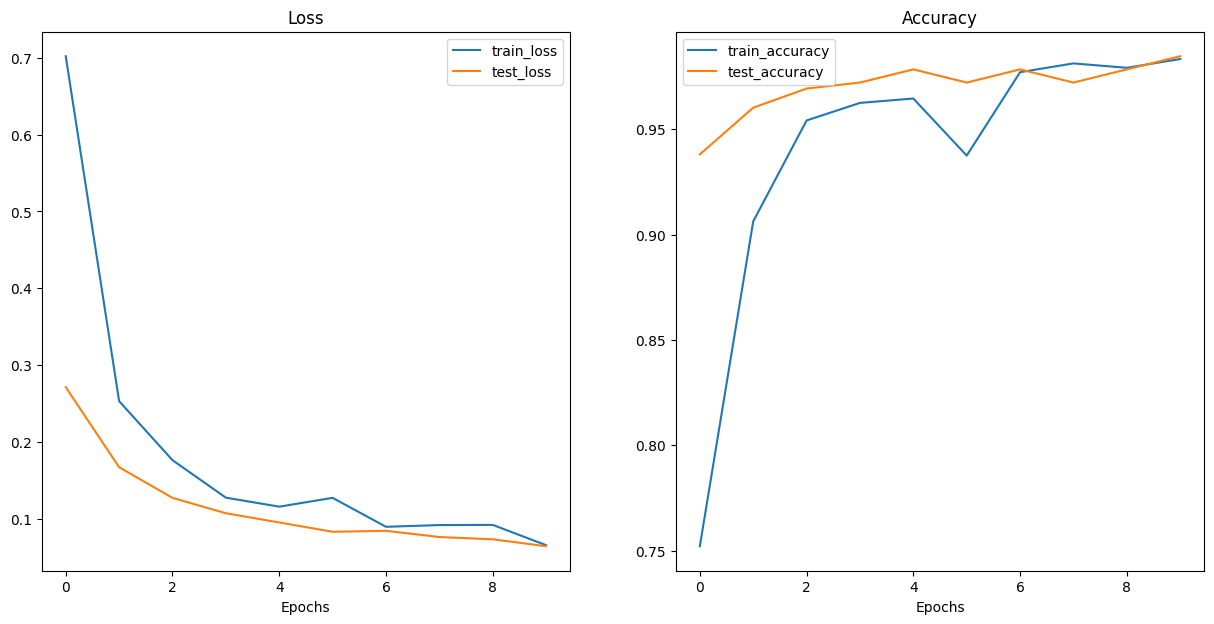

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model = vit,
                 target_dir = "models",
                 model_name = "09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [ ]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6 Collecting ViT feature extractor stats

In [ ]:
# Count number of parameters in ViT (more calculations if more parameters so will take longer mostly)
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create a dictionary with ViT statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing

Our goal:
1. Performs well (95%+ test accuracy)
2. Performs fast (30+ FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on each image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths.

In [ ]:
from pathlib import Path

# Get all the test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/40947.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/289822.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/552171.jpg')]

### 5.1 Creating a function to make a prediction across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms and a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and calculate the prediction probability using torch.`softmax(`) and the target label using `torch.argmax()` since original output will be raw logits.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.

* **`pred_and_store()` is a pretty good utility function for making and storing predictions, it could be stored to `going_modular.going_modular.predictions.py` for later use. Look at notebook 05 for this.**


In [ ]:
import pathlib
import torch

from PIL import Image
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm

# 1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms and a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2. Create an empty listc (can return a full list of all predictions later)
  pred_list = []

  # 3. Loop through the target input paths
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (prediction statistics will go in here)
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open the image using Image.open(path).
    img = Image.open(path)

    # 8. Transform the image to be usable with a given model (also add a batch dimension to predict on a single image and sent to target device)
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model for inference by sending to the target device and turn on eval() mode
    model = model.to(device)
    model.eval()

    # 10. Turn on torch.inference_mode() and pass the target transformed image to the model and calculate the prediction probability using torch.softmax() and the target label using torch.argmax() since original output will be raw logits.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits to pred probs
      pred_label = torch.argmax(pred_prob, dim=1) # pred prob to pred labels
      pred_class = class_names[pred_label.cpu()] # python variables live on CPU as class_name never goes to GPU

      # 11. Add the prediction probability and prediction class to the prediction dictionary created in step 4.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # 13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
    pred_dict["correct"] = class_name == pred_class

    # 14. Append the updated prediction dictionary to the empty list of predictions created in step 2
    pred_list.append(pred_dict)

  # 15. Return the list of prediction dictionaries
  return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (becuase you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appripiate transforms (e.g EffNetB2 with `effnetb2_transforms`)

In [ ]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                         model = effnetb2,
                                         transform = effnetb2_transforms,
                                         class_names = class_names,
                                         device = "cpu") # hardcode predictions to happen on cpu

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.5239,
  'pred_class': 'sushi',
  'time_for_pred': 0.343,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.946,
  'pred_class': 'steak',
  'time_for_pred': 0.1432,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5239,sushi,0.3430,False
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9460,steak,0.1432,True
2,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7708,steak,0.1336,True
3,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9856,steak,0.1271,True
4,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9231,steak,0.1344,True


In [ ]:
# Check the number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1116


**Note:** prediction times will vary (much like training time) depending on the hardware you're using...so generally the faster your compute (e.g CPU or GPU), the faste the predictions will happen.

In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1116}

### 5.3 Making and timing predictions with ViT

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = vit,
                                     transform = vit_transforms,
                                     class_names = class_names,
                                     device ="cpu") # hardcode device on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.5065,
  'pred_class': 'sushi',
  'time_for_pred': 0.6655,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9966,
  'pred_class': 'steak',
  'time_for_pred': 1.095,
  'correct': True}]

In [ ]:
# Turn vit_test_pred_dicts to pandas table
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5065,sushi,0.6655,False
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9966,steak,1.0950,True
2,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9895,steak,0.4697,True
3,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9972,steak,0.4952,True
4,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9123,steak,0.4609,True


In [ ]:
# See how many correct
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [ ]:
# Find the average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.5931


In [ ]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.5931}

## 6. Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29,0.1116,EffNetB2
1,0.064435,98.47,85800963,327,0.5931,ViT


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
  * *sometimes models with higher parameters can still perform fast
* `model_size (MB)` - EffNetB2 (for our case of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` - (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2

Both models fail to achieve our goal of 30+FPS...however we could always try and use EffNetB2 and see how it goes.

In [ ]:
# Compare ViT to EffNetB2 accross different characteristics
pd.DataFrame(data = (df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns = ["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,11.135432,11.275862,5.314516


### 6.1 Visualizing the speed vs Peformance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model size (`model_size(MB)`).

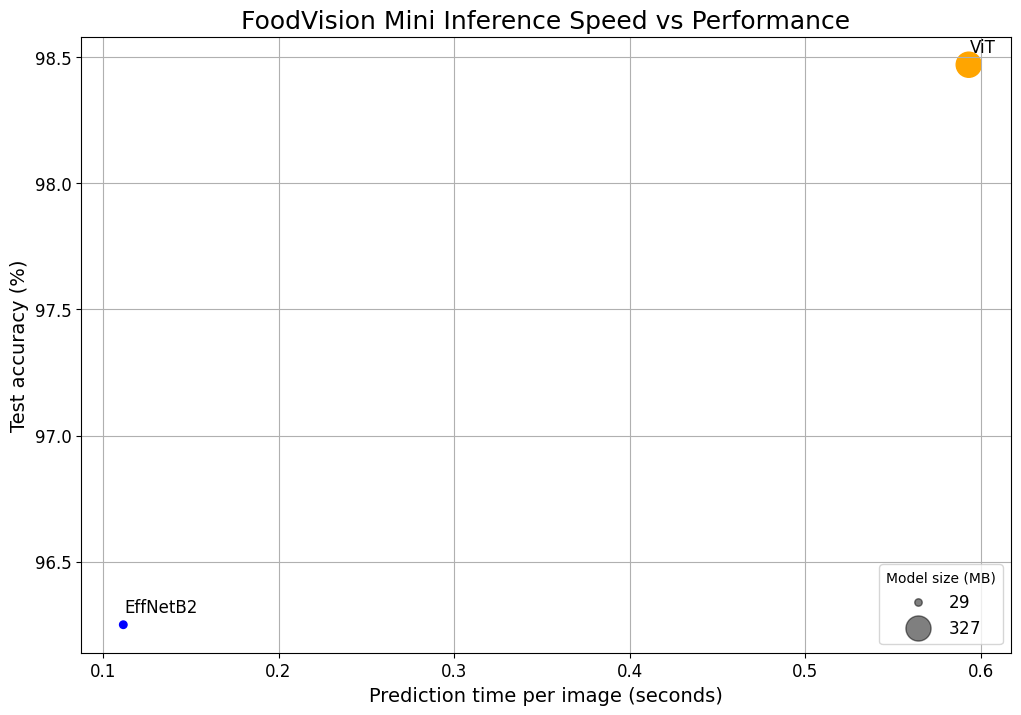

In [ ]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data = df,
                     x = "time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize = 18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize = 14)
ax.set_ylabel("Test accuracy (%)", fontsize = 14)
ax.tick_params(axis="both", labelsize = 12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
  ax.annotate(text = row["model"],
              xy = (row["time_per_pred_cpu"] + 0.0006, row["test_acc"] + 0.05),
              size = 12)

# 4. Create a legend based on the model sizes (model_size (MB))
handles, labels = scatter.legend_elements(prop = "sizes", alpha = 0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc = "lower right",
                              title = "Model size (MB)",
                              fontsize = 12)

# 5. Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision mini to life by creating a Gradio demo

We've chosen to deploy an EffNetB2 as it fulfills our criteria the best.

What is Gradio? (https://www.gradio.app/)

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!



In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.9 MB/s eta 0:00:00
Gradio version: 4.41.0


### 7.1 Gradio overview

Gradio helps you create ML demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> outputs
* in our case: images -> EffNetB2 -> output

### 7.2 Creeating a function to map our inputs and outputs

In [ ]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML Model (EffNetB2) -> outputs (food class label)
```

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension on 0th index

  # Put the model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into pred probabilites
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg

Prediction label and probability dictionary: 
{'pizza': 0.7099605798721313, 'steak': 0.18597376346588135, 'sushi': 0.10406570136547089}
Prediction time: 0.1004 seconds


### 7.3 Creating a list of example images

The examples for Gradio can be created with the `examples` parameter, see here: https://gradio.app/docs/#building-demos

In [ ]:
# Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=10)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/108310.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

In [ ]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description ="An EffNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi: https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights"
article = "Created at 09. PyTorch Model Deployment (github link will be posted soon)"

# Create this Gradio demo
demo = gr.Interface(fn = predict, # maps inputs to outputs
                    inputs = gr.Image(type="pil"),
                    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
                               gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)

# Launch the demo!
demo.launch(debug = False, # print errors locally?
            share = True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e25bb5c90c3deb4e66.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio demo into a deployable app

Our Gradio demo from Google Colab are fantastic but they expire within 72 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spaces.

### 8.1 What is Hugging Face Spaces?

> Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If github is a place to show your coding ability, Hugging Face Spaces is a place to show your ML learning ability (through sharing your ML demos that you've built)

### 8.2 Deployed Gradio app structure

Let's start to put all of our app files into a single directory:

```
Colab -> folder with all the Gradio files -> upload all files to Hugging Face Spaces -> deploy
```

By the end our file structure will be like this:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Why use this structure?

* Because it's one of the simplest we could start with.

You can see this in action:
1. Deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_mini
2. Example file structure - https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main

### 8.3 Create a `demos` folder to store our FoodVision mini app files

In [ ]:
import shutil # allows to do file operations with Python
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents = True,
                                   exist_ok = True)
else:
  foodvision_mini_demo_path.mkdir(parents = True,
                                   exist_ok = True)

!ls demos/foodvision_mini/

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples/` directory
* images should be from the test test

In [ ]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents = True,
                                    exist_ok = True)

# Collect ten random test dataset image paths
foodvision_mini_examples = random.sample(test_data_paths, k=10)

# Copy the ten images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src = example,
               dst = destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg to demos/foodvision_mini/examples/911808.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2549661.jpg to demos/foodvision_mini/examples/2549661.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/2061929.jpg to demos/foodvision_mini/examples/2061929.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg to demos/foodvision_mini/examples/998005.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/48208.jpg to demos/foodvision_mini/examples/48208.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg to demos/foodvision_mini/examples/1166047.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg to demos/foodvision_mini/examples/380739.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2398925.

Let's now verify that we can a list of lists from our `examples` directory

In [ ]:
import os

# Get example filepath in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/715227.jpg'],
 ['examples/1166047.jpg'],
 ['examples/48208.jpg'],
 ['examples/592799.jpg'],
 ['examples/380739.jpg'],
 ['examples/998005.jpg'],
 ['examples/2398925.jpg'],
 ['examples/911808.jpg'],
 ['examples/2549661.jpg'],
 ['examples/2061929.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src = effnetb2_foodvision_mini_model_path,
              dst = effnetb2_foodvision_mini_model_destination)

  print(f"[INFO] model move complete.")
# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps it has already been moved")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] model move complete.


### 8.6 Turning our model into a Python script (`model.py`)

We have a saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:
# Testing that it works
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
# effnetb2_model

### 8.7 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup
2. Model and transforms preperation
3. Predict function (`predict()`)
4. Gradio app = our Gradio interface + launch command

In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preperation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes = len(class_names)
)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location = torch.device("cpu") # load the model to the CPU
    )
)

### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug = False, # print errors locally?
            share = True) # generate a publically shareable URL


Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini `requirements.txt`

The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The three main ones are:
* `torch`
* `torchvision`
* `gradio`

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces

### 9.1 Downloading our FoodVision Mini app files

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

* Uploading via the Hugging Face Web interface (easiest).
* Uploading via the command line or terminal.
  * **Bonus:** You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces.

In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   __pycache__
examples								   requirements.txt


In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini/ && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*__ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: examples/715227.jpg (deflated 1%)
  adding: examples/1166047.jpg (deflated 1%)
  adding: examples/48208.jpg (deflated 15%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/380739.jpg (deflated 0%)
  adding: examples/998005.jpg (deflated 0%)
  adding: examples/2398925.jpg (deflated 0%)
  adding: examples/911808.jpg (deflated 0%)
  adding: examples/2549661.jpg (deflated 0%)
  adding: examples/2061929.jpg (deflated 1%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


In [ ]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our Gradio demo locally

Running the app locally - https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally

### 9.3 Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces

See the steps here: https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/RaahimPoonawala/foodvision_mini/+", width=900, height=750)

## 10. Creating FoodVision Big

FoodVision Mini works well with 3 classes (pizza, steak, sushi)

So all of the experimenting is paying off!

Let's step things up a notch and make FoodVision BIG! using all of the Food101 classes.

### 10.1 Creating a model for FoodVision Big + transforms

In [ ]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

In [ ]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we may want to introduce some data augmentation techniques:
* This is because with larger datasets and larger models, overfitting becomes more of a problem.
* Because we're working with a larger number of classes, let's use TrivialAugment as our data augmentation technique.

For a list of the state-of-the-art computer vision recipes: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [ ]:
# Create training data transforms to stop the model from overfitting due to a large number of classes
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
# Testing data transform stays same to not implement results negatively
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (750 images x 101 classes = 75750 images)
train_data = datasets.Food101(root = data_dir,
                              split = "train",
                              transform = food101_train_transforms, # apply data augmentation to training data
                              download = True)

# Get the testing data (250 images x 101 classes = 25250 images)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform = effnetb2_transforms, # don't perform data augmentation on the test data
                             download=True)

100%|██████████| 4996278331/4996278331 [01:05<00:00, 76259617.94it/s] 


Extracting data/food-101.tar.gz to data


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
print(len(food101_class_names))
print(food101_class_names[:10])

101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


### 10.3 Creating a dataset of the Food101 dataset for faster experimenting

Why create a subset?

We want our first few experiments to run as quick as possible.

We know FoodVision Mini works pretty well but this is the first time we've upgraded to 101 classes.

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test).

Our short-term goal is to beat the original Food101 paper result of 56.40% accuracy on the test dataset (see the paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

We want to beat this result using modern DL techniques and only 20% of the data.



In [ ]:
from torch.utils.data import random_split # https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float = 0.2,
                  seed: int = 42):
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1  # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths = [length_1, length_2],
                                                                 generator = torch.manual_seed(seed))

  return random_split_1, random_split_2

In [ ]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                           split_size = 0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                           split_size = 0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


(15150, 5050)

### 10.4 Turning our Food101 Datasets into `DataLoader's`

In [ ]:
import torch
import os

BATCH_SIZE = 32

NUM_WORKERS = os.cpu_count() # this value is very experimental and the best value will differ depending on the hardware you're using, search `pytorch setup` on Google

# Create Food101 20 training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers = NUM_WORKERS)

# Create Food101 20 testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers = NUM_WORKERS)

len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big!!

Things for training:
* 5 epochs
* Optimizer: `torch.optim.Adam (lr= 0.001)`
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing = 0.1)` -> helps prevent data from overfitting

**What's label smoothing?**

* Label smoothing is a regularization technique (regularization is another word to describe the process of preventing overfitting) that reduces the value a model gives to anyone label and spreads it across the other labels.

* In essence, rather than a model getting too confident on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.

* For example, if a model without label smoothing had the following outputs for 5 classes:
`[0, 0, 0.99, 0.01, 0]`

* A model with label smoothing may have the following outputs:
`[0.01, 0.01, 0.96, 0.01, 0.01]`.
The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params = effnetb2_food101.parameters(),
                             lr = 0.001)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing = 0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model = effnetb2_food101,
                                        train_dataloader = train_dataloader_food101_20_percent,
                                        test_dataloader = test_dataloader_food101_20_percent,
                                        optimizer = optimizer,
                                        loss_fn = loss_fn,
                                        epochs = 5,
                                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4904
Epoch: 2 | train_loss: 2.8612 | train_acc: 0.4441 | test_loss: 2.4615 | test_acc: 0.5464
Epoch: 3 | train_loss: 2.6590 | train_acc: 0.4862 | test_loss: 2.3593 | test_acc: 0.5623
Epoch: 4 | train_loss: 2.5511 | train_acc: 0.5048 | test_loss: 2.3081 | test_acc: 0.5722
Epoch: 5 | train_loss: 2.4928 | train_acc: 0.5213 | test_loss: 2.2731 | test_acc: 0.5827


### 10.6 Inspecting loss curves of FoodVision Big model

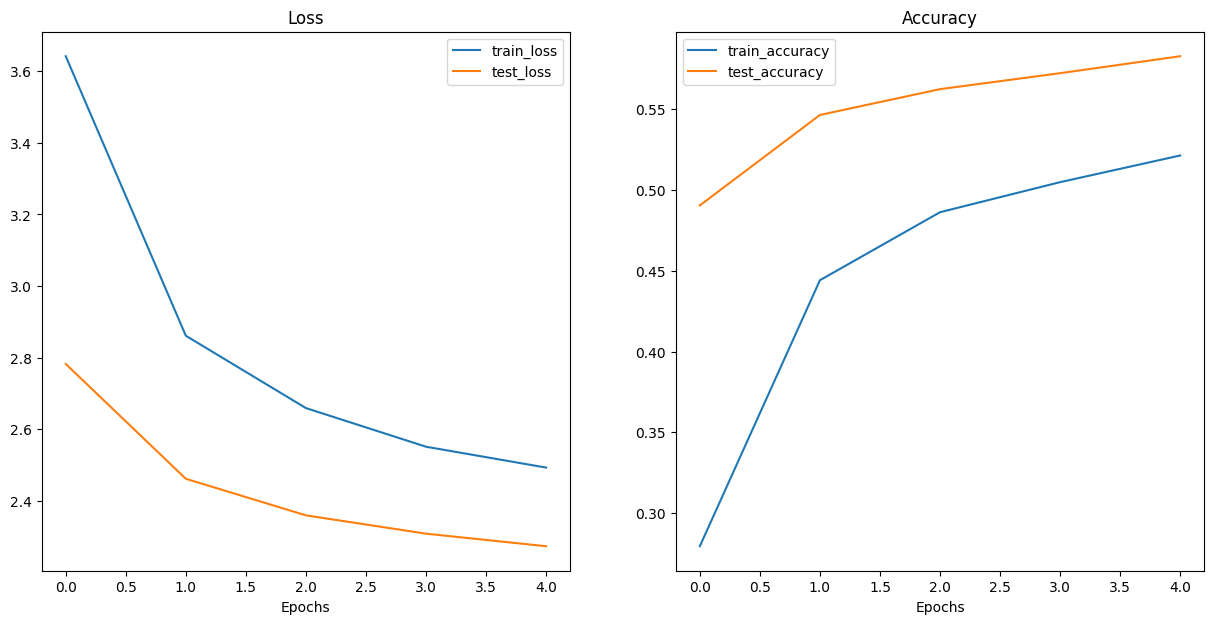

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and load FoodVision Big model

In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model = effnetb2_food101,
                 target_dir = "models/",
                 model_name = effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
# Create Food101 compatibile EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking FoodVision Big model size

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 11. Turning our FoodVision Big model into a deployable app

Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world (the ultimate test set)

Let's create an outline for our FoodVision Big app:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents = True,
                               exist_ok =True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents = True, exist_ok = True)

### 11.1 Downloading an example image and moving it to the `examples` directory

In [ ]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg
!mv image10.jpeg demos/foodvision_big/examples/image10.jpg

test_data_paths = list(Path("data/food-101/images").glob("*/*.jpg"))

# Collect ten random test dataset image paths
foodvision_big_examples = random.sample(test_data_paths, k=20)
foodvision_big_examples_path = Path("demos/foodvision_big/examples")

# Copy the ten images to the examples directory
for example in foodvision_big_examples:
  destination = foodvision_big_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src = example,
               dst = destination)


# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2024-08-16 06:20:01--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.03s   

2024-08-16 06:20:01 (96.0 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]

mv: cannot stat 'image10.jpeg': No such file or directory
[INFO] Copying data/food-101/images/guacamole/732904.jpg to demos/foodvision_big/examples/732904.jpg
[INFO] Copying data/food-101/images/fish_and_chips/1746664.jpg to demos/foodvision_big/examples/1746664.jpg
[INFO] Copying data/food-101/images/beignets/1120044.jpg to demos/foodvision_big/examples/1120044.jpg
[INFO] Cop

### 11.2 Saving Food101 class names to file(`class_names.txt`)

Let's save all of the Food101 class names to a .txt file so we can import them and use them in our app.

In [ ]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [ ]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup - for class names, we'll need to import from `class_names.txt` rather than with a Python list
2. Model and transforms preperation - we'll need to make sure our model is suitable for FoodVision Big
3. Predict function (`predict()`) - this can stay the same as the original `predict()`
4. Gradio app = our Gradio interface + launch command - this will change slightly from FoodVision Mini to reflect the FoodVision Big updates

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preperation ###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = len(class_names))

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
               map_location = torch.device("cpu")) # load to CPU
)

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title, description and article strings
title = "RASP FoodVision 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Overwriting demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.45.0

Overwriting demos/foodvision_big/requirements.txt


### 11.6 Downloading our FoodVision Big app files

In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/image 10.jpeg (deflated 0%)
  adding: examples/2103430.jpg (deflated 0%)
  adding: examples/3846478.jpg (deflated 1%)
  adding: examples/315747.jpg (deflated 0%)
  adding: examples/1370646.jpg (deflated 1%)
  adding: examples/3282057.jpg (deflated 0%)
  adding: examples/2269678.jpg (deflated 1%)
  adding: examples/1691503.jpg (deflated 0%)
  adding: examples/417005.jpg (deflated 0%)
  adding: examples/2582583.jpg (deflated 18%)
  adding: examples/1746664.jpg (deflated 0%)
  adding: examples/1748433.jpg (deflated 1%)
  adding: examples/1269986.jpg (deflated 1%)
  adding: examples/114133.jpg (deflated 0%)
  adding: examples/1514973.jpg (deflated 8%)
  adding: examples/1818389.jpg (deflated 0%)
  adding: examples/3452703.jpg (deflated 1%)
  adding: examples/732904.jpg (deflated 0%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying our FoodVision Big app to HuggingFace Spaces

See here: https://www.learnpytorch.io/09_pytorch_model_deployment/#117-deploying-our-foodvision-big-app-to-huggingface-spaces

In [ ]:
# IPython is a library to help work with Python iteractively
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://hf.space/embed/RaahimPoonawala/Rasp_foodvision/+", width=900, height=750)

## Main-takeaways && Exercises + Extra-curriculum

**Main takeaways:**

* **Deployment is as important as training.** Once you’ve got a good working model, your first question should be: how can I deploy this and make it accessible to others? Deployment allows you to test your model in the real world rather than on private training and test sets.
* **Three questions for machine learning model deployment:**
  1. What’s the most ideal use case for the model (how well and how fast does it perform)?
  2. Where’s the model going to go (is it on-device or on the cloud)?
  3. How’s the model going to function (are predictions online or offline)?
* **Deployment options are a plenty.** But best to start simple. One of the best current ways (I say current because these things are always changing) is to use Gradio to create a demo and host it on Hugging Face Spaces. Start simple and scale up when needed.
* **Never stop experimenting.** Your machine learning model needs will likely change overtime so deploying a single model is not the last step. You might find the dataset changes, so you’ll have to update your model. Or new research gets released and there’s a better architecture to use.
  * So deploying one model is an excellent step, but you'll likely want to update it over time.
* **Machine learning model deployment is part of the engineering practice of MLOps (machine learning operations).** MLOps is an extension of DevOps (development operations) and involves all the engineering parts around training a model: data collection and storage, data preprocessing, model deployment, model monitoring, versioning and more. It’s a rapidly evolving field but there are some solid resources out there to learn more, many of which are in [PyTorch Extra Resources.](https://www.learnpytorch.io/pytorch_extra_resources/#resources-for-machine-learning-and-deep-learning-engineering)

**Exercises (for practice):**

* Qs: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/09_pytorch_model_deployment_exercises.ipynb
* Ans: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/09_pytorch_model_deployment_exercise_solutions.ipynb
* Vid solutions: https://youtu.be/jOX5ZCkWO-0
* Find them here: https://www.learnpytorch.io/09_pytorch_model_deployment/#exercises

**Extra-curriculum (for theory):**
* https://www.learnpytorch.io/09_pytorch_model_deployment/#extra-curriculum